# Optimizing Python Code with [Cython](https://cython.org/)

In [1]:
import Cython
from random import random
import math
import numpy as np
import matplotlib.pyplot as plt

# This is needed to load the Cython magic
%load_ext Cython

## Calculating $\pi$ using Monte Carlo Integration

### Pure Python

In [2]:
def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    in_circle = 0
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [3]:
%time pi_mc(10000000)

CPU times: user 2.1 s, sys: 945 µs, total: 2.1 s
Wall time: 2.1 s


3.1409516

### Cython

#### 1. Use `cython` cell magic without making any code change

In [4]:
%%cython

from random import random

def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    in_circle = 0
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [5]:
%time pi_mc(10000000)

CPU times: user 1.28 s, sys: 3.56 ms, total: 1.28 s
Wall time: 1.28 s


3.1417748

#### 2. Static type declarations in Cython with `cdef`

Static type declarations allow Cython to step out of the dynamic nature of the Python code and produce efficient **C** code.

In [6]:
%%cython

from random import random

def pi_mc(n=1000):
    '''Calculate PI using Monte Carlo method'''
    cdef int in_circle = 0
    cdef int i
    cdef double x, y
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [7]:
%time pi_mc(10000000)

CPU times: user 398 ms, sys: 187 µs, total: 398 ms
Wall time: 398 ms


3.1415044

#### 3. Using Cython `annotate` option and inspect the generated C code

In [8]:
%%cython --annotate

from random import random

def pi_mc(int n=1000):
    '''Calculate PI using Monte Carlo method'''
    cdef:
        int in_circle = 0
        int i
        double x, y
    for i in range(n):
        x, y = random(), random()
        if x ** 2 + y ** 2 <= 1.0:
            in_circle += 1
        
    return 4.0 * in_circle / n

In [9]:
%time pi_mc(10000000)

CPU times: user 401 ms, sys: 0 ns, total: 401 ms
Wall time: 400 ms


3.1419604

## Types of Cython functions

Cython offers three different types of function declared with `def`, `cdef`, `cpdef`:

1. Functions declared with `def` can be called from Python and Cython code.
2. Functions declared with `cdef` can be only called from Cython code.
3. `cpdef` causes Cython to create two versions of the function. One which is used when the function is called from Cython code and one when it is called from Python.

In [10]:
%%cython 


cdef double cube(double x):
    return x * x * x


cpdef double cube_sum(double x, double y):
    return cube(x) + cube(y)

### Function Inlining

We can use the `cdef inline` for small functions that are used often and Cython inlines them reducing overhead

In [11]:
%%cython --annotate


cdef inline double cube(double x):
    return x * x * x


cpdef double cube_sum(double x, double y):
    return cube(x) + cube(y)

## Typed Memory Views

Cython allows access to the contents of NumPy arrays by **memory views**.

In [12]:
%%cython --annotate

def my_sum(double[:] x):
    cdef int i, n = x.shape[0]
    cdef double s = 0.0
    for i in range(n):
        s += x[i]
        
    return s

In [13]:
x = np.ones(1000, dtype=np.float64)
s1 = my_sum(x)
s2 = x.sum()
print(s1, s2)

1000.0 1000.0


In [14]:
%%cython --annotate

def my_sum2d(double[:, :] x):
    cdef int i, j, rows = x.shape[0], columns = x.shape[1]
    cdef double s = 0.0
    for i in range(rows):
        for j in range(columns):
            s += x[i, j]
        
    return s

In [15]:
x = np.ones((1000, 1000), dtype=np.float64)
s1 = my_sum2d(x)
s2 = x.sum()
print(s1, s2)

1000000.0 1000000.0


## Disable bounds checking and wraparound

For safety reasons, Cython checks if we try to access elements out of the array boundaries. 
Furthermore it allows using negative array indices. We can exhange safety with performance disabling both of them.


In [16]:
%%cython --annotate

from cython cimport wraparound, boundscheck

@wraparound(False)
@boundscheck(False)
cpdef double my_sum2d(double[:, :] x):
    cdef int i, j, rows = x.shape[0], columns = x.shape[1]
    cdef double s = 0.0
    for i in range(rows):
        for j in range(columns):
            s += x[i, j]
        
    return s

## Releasing the GIL and parallelizing loops

### Calculating Julia Sets

In [17]:
%%cython

from cython cimport boundscheck, wraparound

@wraparound(False)
@boundscheck(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
        
    ny = X.shape[0]
    nx = X.shape[1]
   
    for i in range(ny):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

593 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


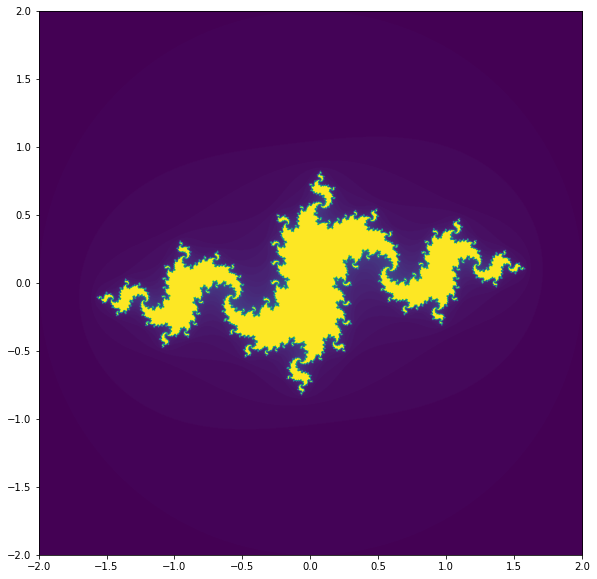

In [18]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

In [19]:
%%cython

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = X.shape[1]
    for i in prange(ny, nogil=True):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

595 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


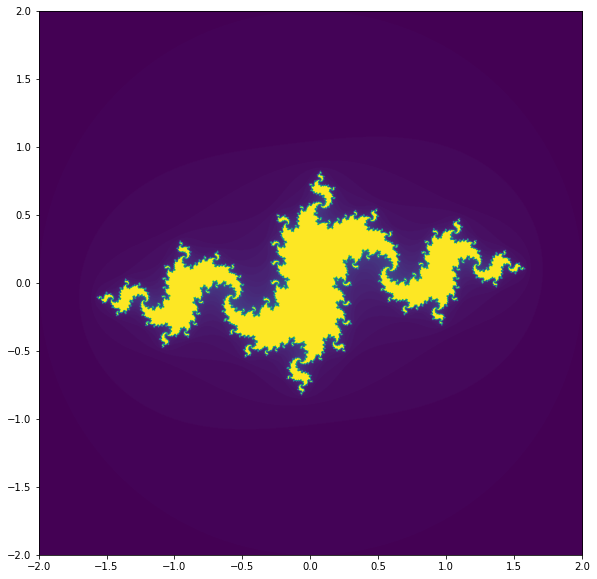

In [20]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

In [21]:
%%cython

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = X.shape[1]
    for i in prange(ny, nogil=True):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

593 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


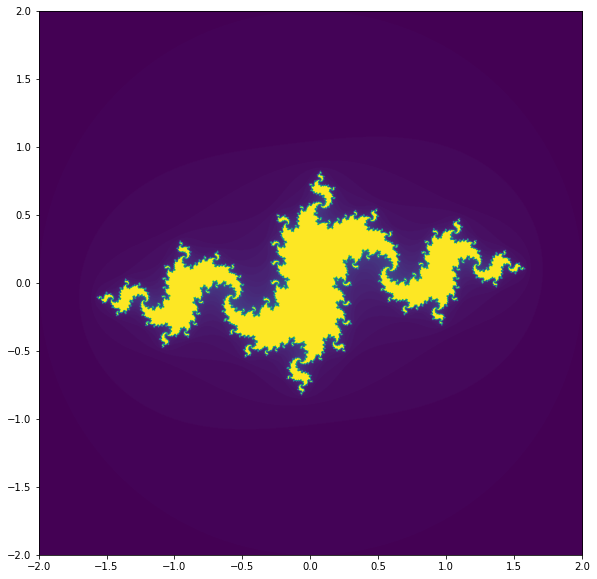

In [22]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

### !!! WE FORGOT TO PUT THE CORRECT COMPILATION/LINKING OPTIONS !!!

In [23]:
%%cython

# distutils: extra_compile_args = -fopenmp -march=native
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = X.shape[1]
    for i in prange(ny, nogil=True):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k

214 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


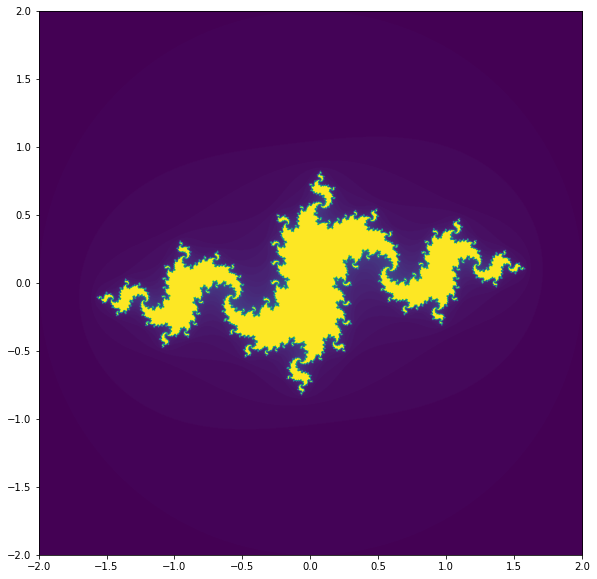

In [24]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
%timeit julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);